In [2]:
import os
from os.path import abspath, dirname
import shutil as sh
from io import StringIO
from icecream import ic
import fitz

from PIL import Image
from PIL import ImageFilter
from matplotlib import pyplot as plt 
import pytesseract
import numpy as np
import cv2
import pandas as pd
from collections import defaultdict
import statistics
from functools import reduce  # merging multi dataframe


## Image extraction from PDF 

In [139]:
def extract_img(file_name, save_img):
    sh.rmtree(save_img)  # delete this folder
    # if file don't exist, then create
    try:
        os.makedirs(save_img)
    except:
        print ("Directory already exist.")

    img_count = 0
    file_name1, _ = os.path.splitext(file_name)
    absolute_path = os.path.join(folder_path, file_name)

    doc = fitz.open(absolute_path)  # Document('.pdf')
    lenXREF = doc.xref_length()  # the number of entries in the xref table (cross-reference number)
    print(f'file name: {file_name}, the number of pages: {len(doc)}, length of xref table: {lenXREF - 1}')

    # extract images from each pages
    for idx, page in enumerate(doc): 
        imgs_list = page.get_images()  # the number of images in each page  
        for i in imgs_list:
            single_img = list(i)  # tuple -> list          
            xref = single_img[0]   
            img = doc.extract_image(xref)  # get image info

            # delete too small images, that may not be a chart
            pix = fitz.Pixmap(doc, xref)
            if pix.size < 10000: continue 
            img_count += 1

            # add images into folder
            img_name = f'{img_count}_p{idx+1}.' + img["ext"]  
            img_name = file_name1 + "_" + img_name
            img_path = os.path.join(save_img, img_name)   
            
            img_out = open(img_path, 'wb')   
            img_out.write(img["image"])   
            img_out.close

    print(f'Extraction finished. Total images: {img_count}')


file_name = 'sample5.pdf'
folder_path = abspath(dirname(file_name))  # get the direction
save_img = folder_path + '/imagesss'

extract_img(file_name, save_img)

file name: sample5.pdf, the number of pages: 54, length of xref table: 1326
Extraction finished. Total images: 4


## Applying image preprocessing (sometimes result is better)

Sharpening image

Text(0.5, 1.0, 'Kernel2')

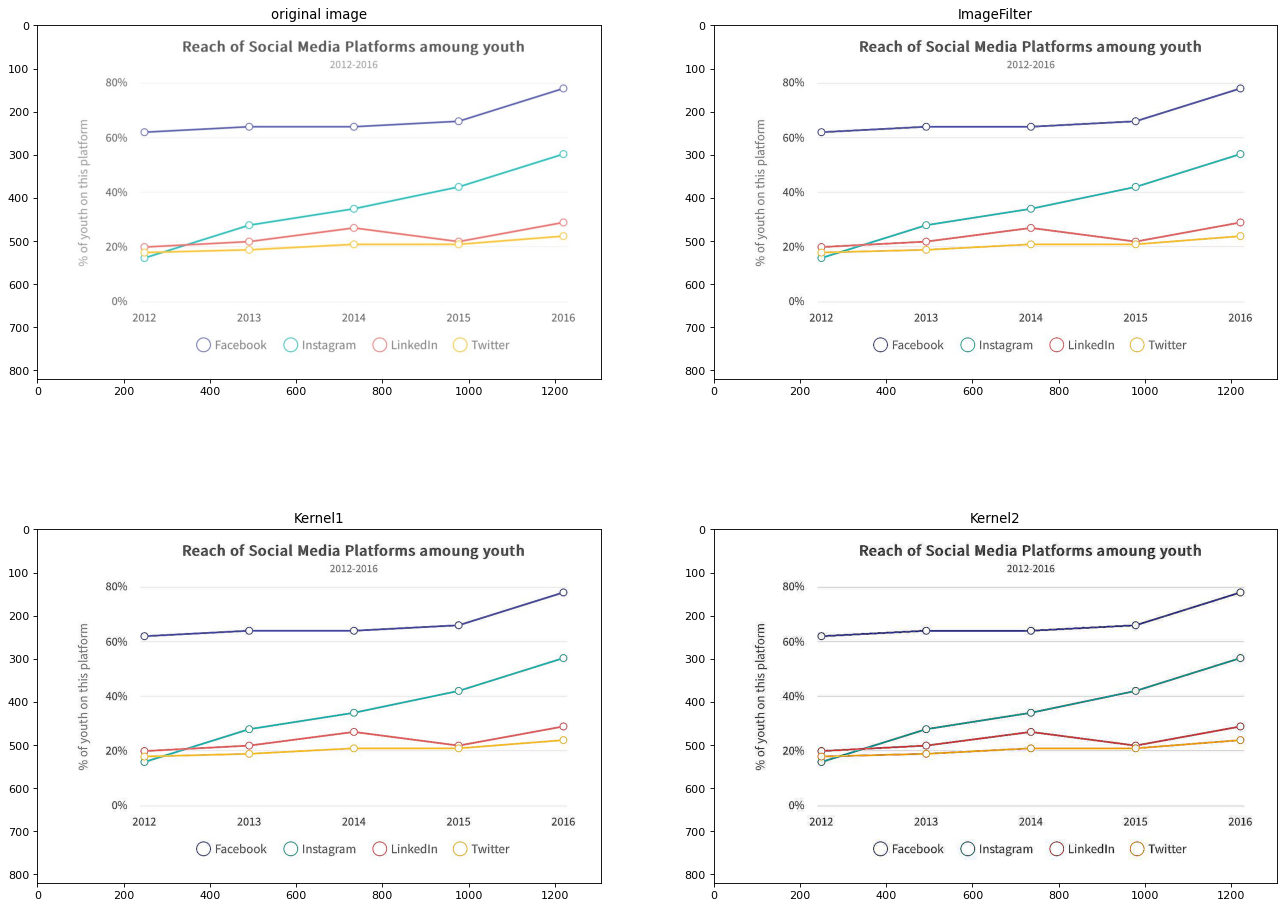

In [3]:
def cv2_PIL(original_img):
    img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    return img


def kernel_PIL(original_img, kernel):
    img = cv2.filter2D(original_img, -1, kernel)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    return img


original_img = cv2.imread('line_chart_color3.jpeg')

img1 = cv2_PIL(original_img)
img2 = img1.filter(ImageFilter.SHARPEN)
img2 = img2.filter(ImageFilter.SHARPEN)

kernel1 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  
kernel2 = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
img3 = kernel_PIL(original_img, kernel1)
img4 = kernel_PIL(original_img, kernel2)

figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15), dpi=80)
ax[0][0].imshow(img1)
ax[0][0].set_title('original image')
ax[0][1].imshow(img2)
ax[0][1].set_title('ImageFilter')
ax[1][0].imshow(img3)
ax[1][0].set_title('Kernel1')
ax[1][1].imshow(img4)
ax[1][1].set_title('Kernel2')

In [4]:
# eliminate noise
def img_preprocessing(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    norm_img = np.zeros((image.shape[0], image.shape[1]))
    image = cv2.normalize(image, norm_img, 0, 255, cv2.NORM_MINMAX)
    image = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY)[1]  # > threshold 120, set it to maxval 255 white, otherwise 0 black
    image = cv2.GaussianBlur(image, (1, 1), 0)  # Gaussian Smoothing
    return image


# using PIL show image
def Image_show(original_img, image):
    img_cvt1 = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    img_cvt1 = Image.fromarray(img_cvt1)
    img_cvt2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_cvt2 = Image.fromarray(img_cvt2)

    figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
    ax[0].imshow(img_cvt1)
    ax[1].imshow(img_cvt2)


# using cv2 show image
def show(name, img):
    cv2.imshow(name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)

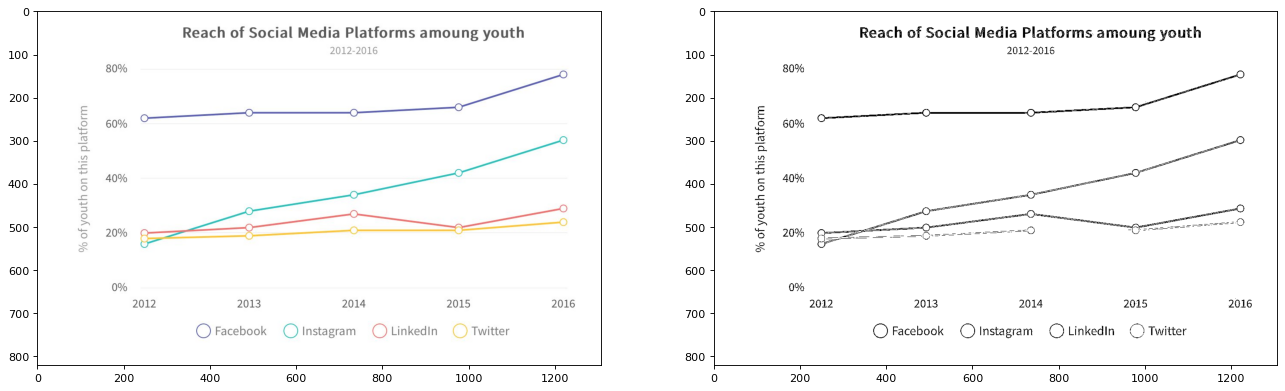

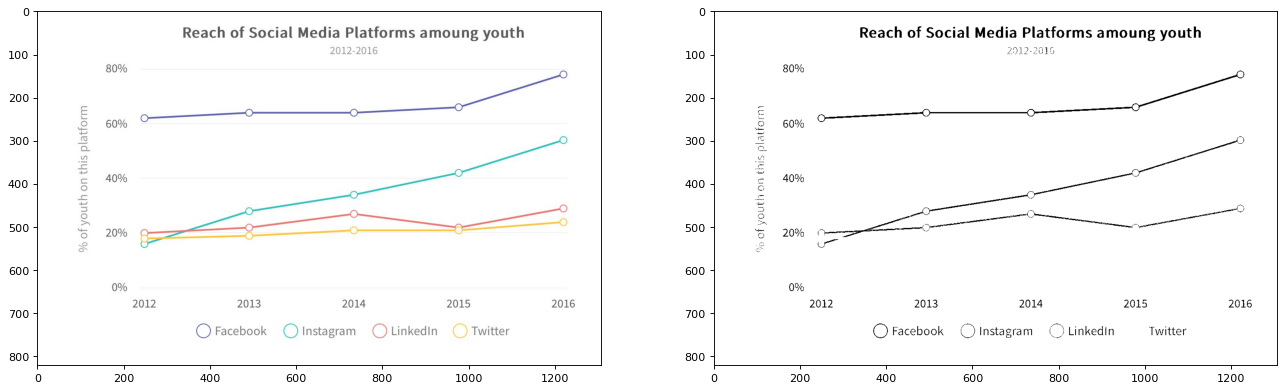

In [5]:
# using sharpened image
img = cv2.cvtColor(np.array(img4), cv2.COLOR_RGB2BGR)
img = img_preprocessing(img)
Image_show(original_img, img)

# using original image
img = img_preprocessing(original_img)
Image_show(original_img, img)

## Extracting coordinate system info

In [6]:
def text_extraction(original_img, sharpened_img, flag):
    if flag == 0: 
        img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  
    elif flag == 1:
        img_pre = img_preprocessing(original_img)
        img_rgb = cv2.cvtColor(img_pre, cv2.COLOR_BGR2RGB)  
    elif flag == 2:
        img_rgb = sharpened_img
    elif flag == 3:
        img = cv2.cvtColor(np.array(sharpened_img), cv2.COLOR_RGB2BGR)
        img = img_preprocessing(img)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    data = pytesseract.image_to_data(img_rgb)
    # convert to dataframe and delete nan values and blank spaces
    df = pd.read_csv(StringIO(data), sep='\t')
    df = df.dropna().reset_index().drop(labels='index', axis=1)
    df = df[~df['text'].isin([' ','  ','   '])]

    return df

# 0: original image, 1: original image with image processing, 2: sharpened image, 3: sharpened image with image processing
df = text_extraction(original_img, img4, 1)
df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,5,1,1,1,1,1,339,38,96,26,95.944572,Reach
1,5,1,1,1,1,2,449,38,32,26,96.452232,of
2,5,1,1,1,1,3,492,38,100,26,96.190025,Social
3,5,1,1,1,1,4,606,38,95,26,96.800972,Media
4,5,1,1,1,1,5,716,38,160,26,96.621689,Platforms
5,5,1,1,1,1,6,888,46,134,26,96.454834,amoung
6,5,1,1,1,1,7,1034,38,94,34,96.783867,youth
7,5,1,1,1,2,1,680,86,108,16,94.421112,2912-2016
8,5,1,2,1,1,1,160,125,48,19,96.709343,80%
9,5,1,3,1,1,1,160,253,48,19,96.117615,60%


This part is related to the layout of charts. It must to be corrected or changed.

In [7]:
# title lies on the top-most of the chart in most cases
title = df[df.top == df.top.min()].text.values
# title = df[df.top == sorted(set(df.top.values))[2]].text.values
title = ' '.join(title)
ic(title)


# y label lies on the left-most of the chart in most cases, adjacent to y-axis
y_label = df[df.left == df.left.min()].text.values
y_label = ' '.join(y_label)

y_set_point = sorted(set(df.left.values))[3]
# y_axis = df[df.left == set_point].text.values
y_df = df[df.left.between(y_set_point-1, y_set_point+20)]
y_axis = y_df.text.values
# y_axis = list(map(lambda x: int(x), y_axis))  # str -> int 
y_top_pixel = y_df.top.values
y_h_pixel = y_df.height.values
ic(y_label, y_axis, y_top_pixel, y_h_pixel)  # 0 was not recognized


# x label lies on the bottom-most of the chart in most cases, adjacent to x-axis
# x_label = df[df.top == df.top.max()].text.values
# x_label = ' '.join(x_label)

# x_df = df[df.top == sorted(set(df.top.values))[-2]]
x_set_point = sorted(set(df.top.values))[-5]
x_df = df[df.top.between(x_set_point-1, x_set_point+1)]
x_axis = x_df.text.values
x_left_pixel = x_df.left.values 
x_w_pixel = x_df.width.values 
# ic(x_label, x_axis, x_left_pixel, x_w_pixel)
ic(x_axis, x_left_pixel, x_w_pixel)

ic| title: 'Reach of Social Media Platforms youth'
ic| y_label: '80% 60% 40% 20%'
    y_axis: array(['Reach'], dtype=object)
    y_top_pixel: array([38])
    y_h_pixel: array([26])
ic| x_axis: array(['2012', '2013', '2014', '2015', '2016'], dtype=object)
    x_left_pixel: array([ 222,  465,  708,  950, 1193])
    x_w_pixel: array([53, 53, 53, 53, 53])


(array(['2012', '2013', '2014', '2015', '2016'], dtype=object),
 array([ 222,  465,  708,  950, 1193]),
 array([53, 53, 53, 53, 53]))

In [8]:
# legend
legend_set_point = sorted(set(df.top.values))[-2]
legend_df = df[df.top.between(legend_set_point-1, legend_set_point+1)]
legend = legend_df.text.values
legend_left_pixel = legend_df.left.values 
legend_w_pixel = legend_df.width.values 
legend_top_pixel = legend_df.top.values 
legend_h_pixel = legend_df.height.values 
ic(legend, legend_left_pixel, legend_w_pixel, legend_top_pixel, legend_h_pixel)

ic| legend: array(['Facebook', 'Instagram', 'Linkedin', 'Twitter'], dtype=object)
    legend_left_pixel: array([ 415,  617,  823, 1008])
    legend_w_pixel: array([117, 120, 103,  87])
    legend_top_pixel: array([731, 733, 731, 732])
    legend_h_pixel: array([21, 25, 21, 20])


(array(['Facebook', 'Instagram', 'Linkedin', 'Twitter'], dtype=object),
 array([ 415,  617,  823, 1008]),
 array([117, 120, 103,  87]),
 array([731, 733, 731, 732]),
 array([21, 25, 21, 20]))

find real x and y piexel value

x_real_pixel = x_left_pixel + x_w_pixel / 2

y_real_pixel = y_top_pixel + y_h_pixel / 2

In [9]:
x_real_pixel = x_left_pixel + x_w_pixel / 2
y_real_pixel = y_top_pixel + y_h_pixel / 2
ic(x_real_pixel, y_real_pixel)

ic| x_real_pixel: array([ 248.5,  491.5,  734.5,  976.5, 1219.5])
    y_real_pixel: array([51.])


(array([ 248.5,  491.5,  734.5,  976.5, 1219.5]), array([51.]))

If incorrectly recognized or if some are not recognized, below correct it.

In [10]:
y_pixel_max = y_real_pixel[-1]
ic(x_axis, y_axis, y_real_pixel, y_pixel_max)

ic| x_axis: array(['2012', '2013', '2014', '2015', '2016'], dtype=object)
    y_axis: array(['Reach'], dtype=object)
    y_real_pixel: array([51.])
    y_pixel_max: 51.0


(array(['2012', '2013', '2014', '2015', '2016'], dtype=object),
 array(['Reach'], dtype=object),
 array([51.]),
 51.0)

## Color isolation

find color range

In [11]:
# RGB -> HSV, lower -20, upper +20. 
l = np.uint8([[[252,103,107]]])  # RGB
u = np.uint8([[[227,151,146]]])  # RGB

lower = np.array(cv2.cvtColor(l, cv2.COLOR_BGR2HSV))
upper = np.array(cv2.cvtColor(u, cv2.COLOR_BGR2HSV))
ic(lower, upper)

ic| lower: array([[[121, 151, 252]]], dtype=uint8)
    upper: array([[[118,  91, 227]]], dtype=uint8)


(array([[[121, 151, 252]]], dtype=uint8),
 array([[[118,  91, 227]]], dtype=uint8))

In [325]:
# RGB -> HSV, lower -20, upper +20. 
l = np.uint8([[[244,189,77]]])  # RGB
u = np.uint8([[[255,238,161]]])  # RGB

lower = np.array(cv2.cvtColor(l, cv2.COLOR_BGR2HSV))
upper = np.array(cv2.cvtColor(u, cv2.COLOR_BGR2HSV))
ic(lower, upper)

ic| lower: array([[[100, 175, 244]]], dtype=uint8)
    upper: array([[[ 95,  94, 255]]], dtype=uint8)


(array([[[100, 175, 244]]], dtype=uint8),
 array([[[ 95,  94, 255]]], dtype=uint8))

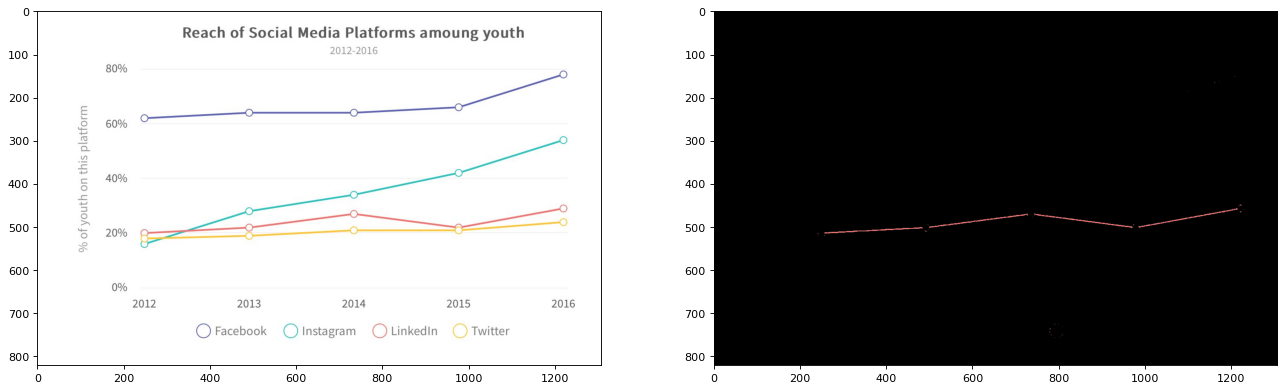

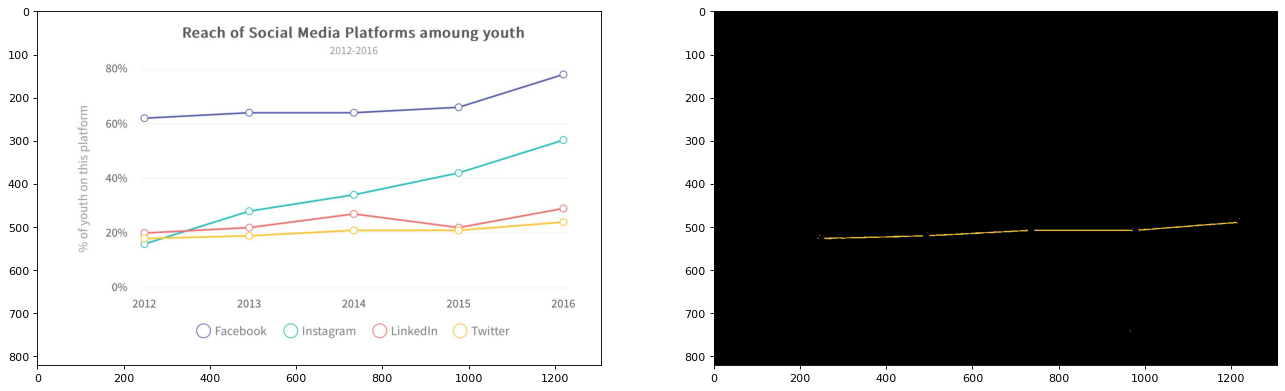

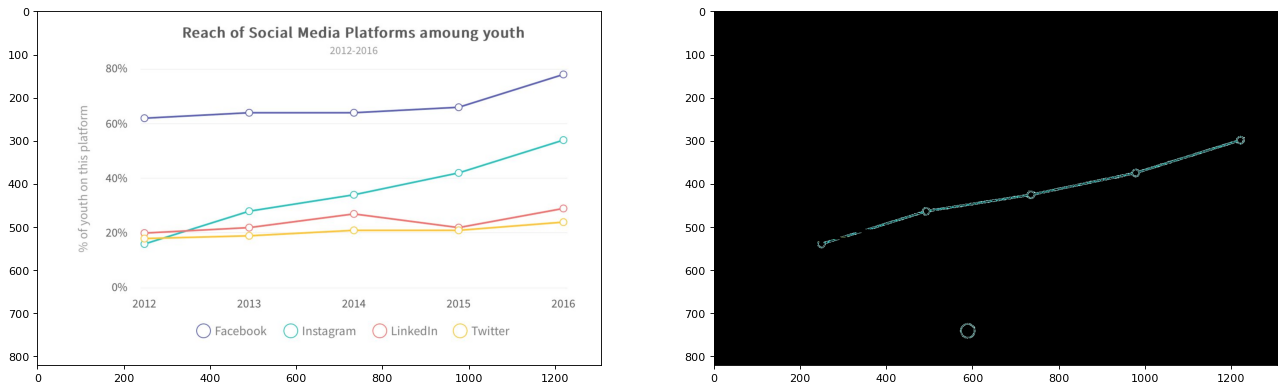

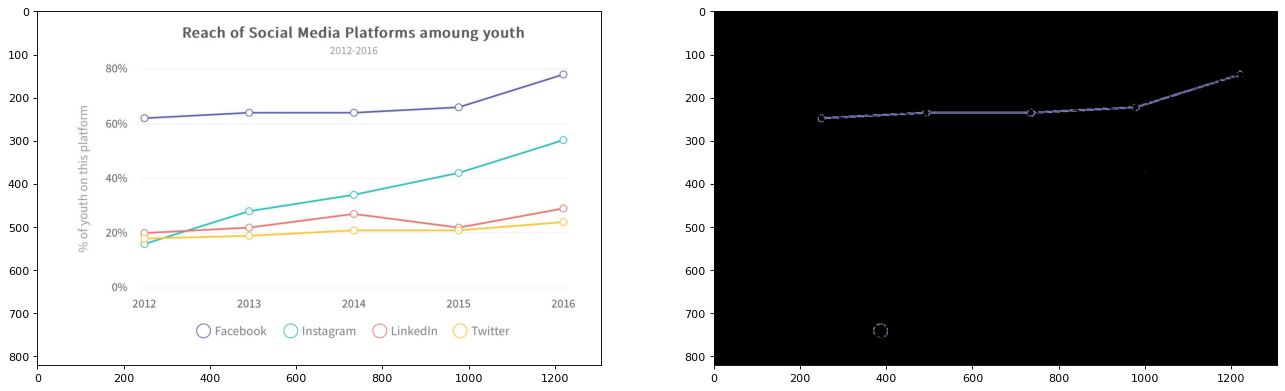

In [15]:
def color_separation(original_img, lowerb, upperb):
    # convert to HSV
    img_hsv = cv2.cvtColor(original_img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(img_hsv, lowerb, upperb)
    # separate color with mask
    img_masked = cv2.bitwise_and(original_img, original_img, mask=mask)
    return img_masked

red_lowerb = np.array([110,110,190])  # measured using software
red_upperb = np.array([210,220,250])  
# red_lowerb = np.array([110,70,210])  # measured by calculation
# red_upperb = np.array([141,170,255])  
# red_lowerb = np.array([110,70,200])  # tune the range
# red_upperb = np.array([255,255,255]) 

# yellow_lowerb = np.array([90,150,220])  # measured using software
# yellow_upperb = np.array([200,255,255])
yellow_lowerb = np.array([95,150,225])
yellow_upperb = np.array([255,255,255])

blue_lowerb = np.array([20,30,190])
blue_upperb = np.array([80,255,255])
# blue_lowerb = np.array([100,150,0])  # ?
# blue_upperb = np.array([140,255,255])

purple_lowerb = np.array([0, 20, 108])
purple_upperb = np.array([10, 255, 255])


img_red = color_separation(original_img, red_lowerb, red_upperb)
img_yellow = color_separation(original_img, yellow_lowerb, yellow_upperb)
img_blue = color_separation(original_img, blue_lowerb, blue_upperb)
img_purple = color_separation(original_img, purple_lowerb, purple_upperb)

Image_show(original_img, img_red)
Image_show(original_img, img_yellow)
Image_show(original_img, img_blue)
Image_show(original_img, img_purple)


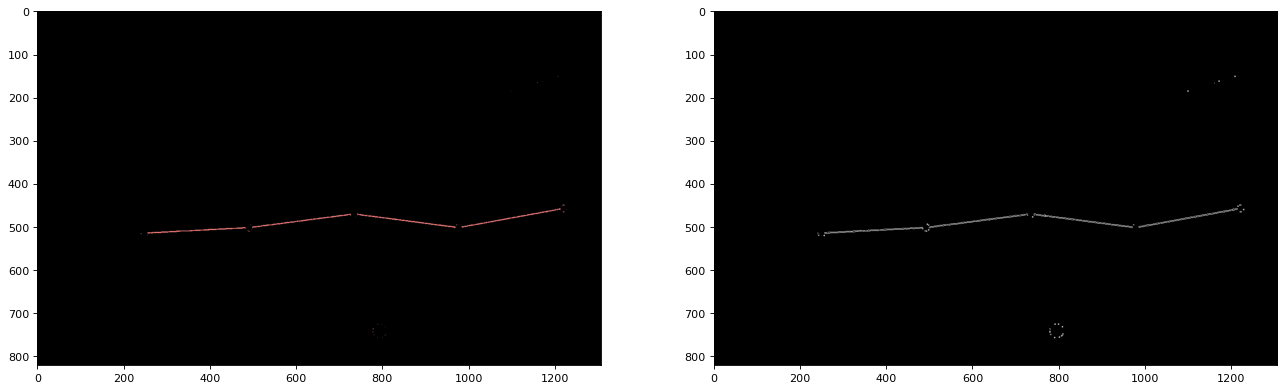

In [301]:
def find_contour(image):
# gray= cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(image, 50, 200)
    # _, edges = cv2.threshold(gray, 150, 200, cv2.THRESH_BINARY)  # apply binary thresholding
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return edges, contours


edges_red, contours_red = find_contour(img_red)
edges_yellow, contours_yellow = find_contour(img_yellow)
edges_blue, contours_blue = find_contour(img_blue)
edges_purple, contours_purple = find_contour(img_purple)

Image_show(img_red, edges_red)

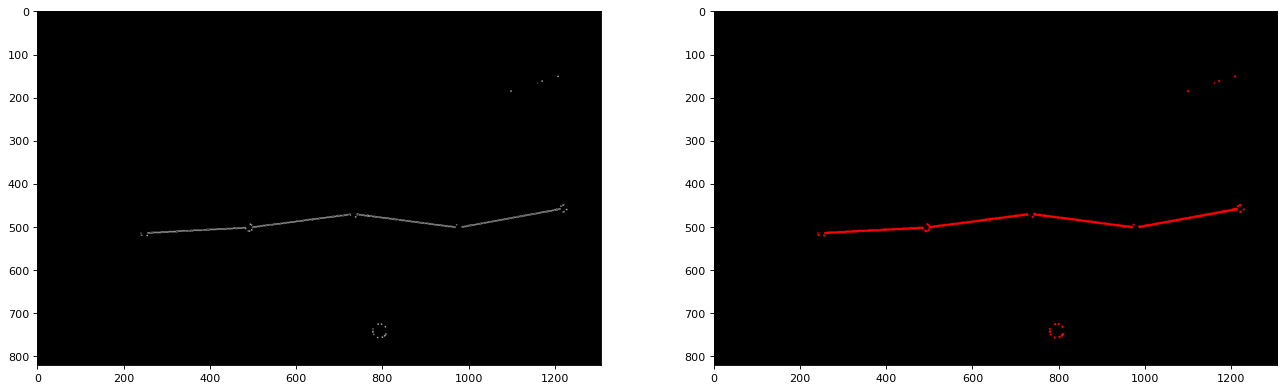

In [302]:
# draw the red contours
tmp = cv2.drawContours(img_red, contours_red, -1, (0,0,255), 2)  
Image_show(edges_red, tmp)

## Calculate real y-axis value based on proportion

### Finding legend

In [303]:
def current_legend(contours):
    legend_lower = max(set(legend_top_pixel.tolist()), key=legend_top_pixel.tolist().count)
    legend_upper = legend_top_pixel + legend_h_pixel
    legend_upper = max(set(legend_upper.tolist()), key=legend_top_pixel.tolist().count)

    legend_dic = defaultdict(list)
    for i in contours:
        for j in i:
            if legend_lower <= j[0][1] <= legend_upper:
                legend_dic[j[0][0]].append(j[0][1])

    legend_max = max(legend_dic.keys())
    idx = np.argmin(np.absolute(legend_max - legend_left_pixel))
    cur_legend = legend[idx]
    return cur_legend


legend_red = current_legend(contours_red)
legend_yellow = current_legend(contours_yellow)
legend_blue = current_legend(contours_blue)
legend_purple = current_legend(contours_purple)

### Diskrete output value of y

In [280]:
def discrete(tolerance, contours):
    y_dic = defaultdict(list)
    for i in contours:
        for j in i:
            if j[0][0] in x_real_pixel and y_real_pixel[0] <= j[0][1] <= y_real_pixel[-1]:
                y_dic[j[0][0]].append(j[0][1])
    x_y_value = sorted(y_dic.items(), key=lambda x:x[0])

    exist_value = []
    for i in x_y_value:
        exist_value.append(i[0])

    missing_value = []
    for i in x_real_pixel:
        if i not in exist_value:
            missing_value.append(i)

    # using the adjacent x-axis value to find y-axis value
    missing_value_dic = defaultdict(list)
    for i in contours:
        for j in i:
            for m in missing_value:
                if m-tolerance <= j[0][0] <= m+tolerance and y_real_pixel[0] <= j[0][1] <= y_real_pixel[-1]:
                    missing_value_dic[j[0][0]].append(j[0][1])
                    missing_value.remove(m)  # make sure only add one value
                    if len(missing_value) == 0:
                        break
    
    # combine two dic
    y_dic.update(missing_value_dic)
    x_y_value = sorted(y_dic.items(), key=lambda x:x[0])

    x_y_value_mean = [np.mean(i[1]) for i in x_y_value]
    y_pixel_min = y_real_pixel[0]
    # y_axis_max = int(y_axis[0])
    y_axis_max = float(y_axis[0].strip('%')) / 100.0 

    y_axis_value = []
    for i in x_y_value_mean:
        y = (y_pixel_max - i) / (y_pixel_max - y_pixel_min) * y_axis_max
        y = round(y, 4)
        y_axis_value.append(y)

    return y_axis_value

In [281]:
tolerance = 6

# img_red = color_separation(original_img, red_lowerb, red_upperb)
# _, contours_red = find_contour(img_red)
# legend_red = current_legend(contours_red)
y_axis_value_dis_red = discrete(tolerance, contours_red)

# img_yellow = color_separation(original_img, yellow_lowerb, yellow_upperb)
# _, contours_yellow = find_contour(img_yellow)
# legend_yellow = current_legend(contours_yellow)
y_axis_value_dis_yellow = discrete(tolerance, contours_yellow)

# img_blue = color_separation(original_img, blue_lowerb, blue_upperb)
# _, contours_blue = find_contour(img_blue)
# legend_blue = current_legend(contours_blue)
y_axis_valu_dis_blue = discrete(tolerance, contours_blue)

# img_purple = color_separation(original_img, purple_lowerb, purple_upperb)
# _, contours_purple = find_contour(img_purple)
# legend_purple = current_legend(contours_purple)
y_axis_value_dis_purple = discrete(tolerance, contours_purple)

In [299]:
data_dis = []
y_axis_value_dis = [y_axis_value_dis_purple, y_axis_valu_dis_blue, y_axis_value_dis_red, y_axis_value_dis_yellow]

for i, name in enumerate(legend):
    df = pd.DataFrame({'time': x_axis, name: y_axis_value_dis[i]})
    data_dis.append(df)

data_dis = reduce(lambda left, right: pd.merge(left, right, on='time', how='inner'), data_dis)
data_dis

,time,Facebook,Instagram,Linkedin,Twitter
0,2012,0.6047,0.1447,0.1905,0.1668
1,2013,0.6269,0.2851,0.2047,0.1826
2,2014,0.6237,0.3249,0.2585,0.1968
3,2015,0.6625,0.4119,0.2300,0.1953
4,2016,0.7692,0.5526,0.2743,0.2506


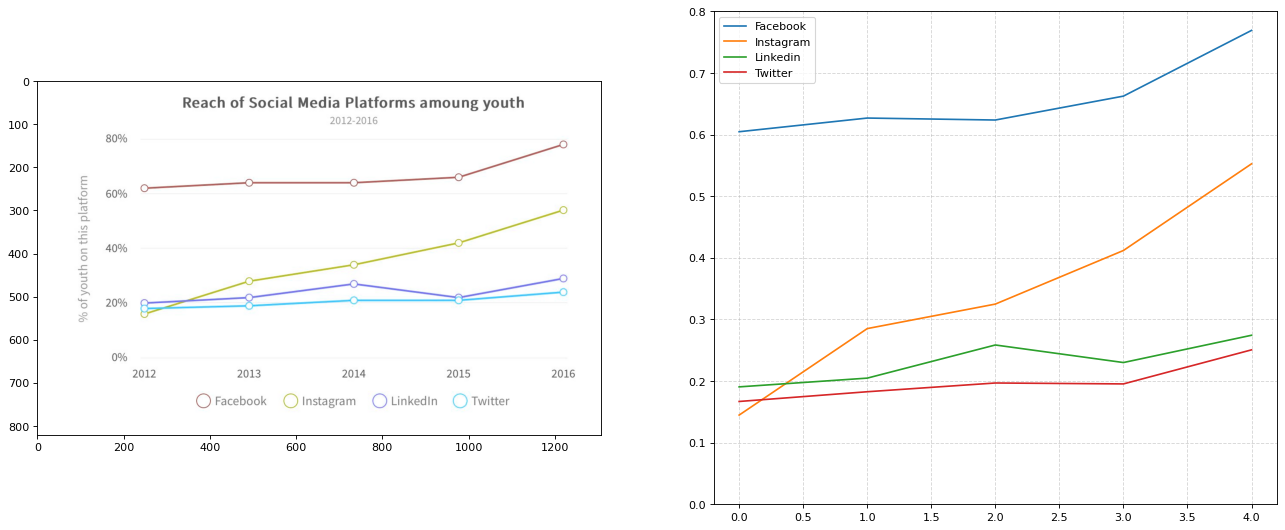

In [360]:
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
ax[0].imshow(original_img)
for i in legend:
    ax[1].plot(data_dis[i], label=i)
ax[1].set_ylim(0,0.8)
ax[1].grid(linestyle='--', alpha=0.5)
ax[1].legend()

### Continuous output value of y

In [356]:
# img_w, img_l = original_img.shape[0], original_img.shape[1]
y_pixel_min = y_real_pixel[0]
# y_axis_max = int(y_axis[0])
y_axis_max = float(y_axis[0].strip('%')) / 100.0 
y_axis_max

0.8

In [357]:
def continuous(contours):
    y_dic = defaultdict(list)
    for i in contours:
        for j in i:
            if x_real_pixel[0] <= j[0][0] <= x_real_pixel[-1] and y_real_pixel[0] <= j[0][1] <= y_real_pixel[-1]:
                y_dic[j[0][0]].append(j[0][1])

    x_y_value = sorted(y_dic.items(), key=lambda x:x[0])

    x_y_value_mean = []
    x_axis_con = []
    for i in x_y_value:
        x, y = i
        # y_mean = statistics.mean(y)
        y_mean = np.mean(y)
        # y_mean = max(set(y),key=y.count)

        x_y_value_mean.append(y_mean)
        x_axis_con.append(x)

    y_axis_value = []
    for i in x_y_value_mean:
        y = (y_pixel_max - i) / (y_pixel_max - y_pixel_min) * y_axis_max
        # y = round(y, 2)
        y = round(y, 6)
        y_axis_value.append(y)

    return x_axis_con, y_axis_value

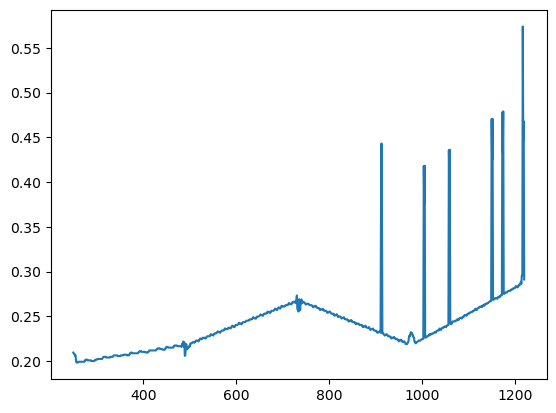

In [358]:
img_red = color_separation(original_img, red_lowerb, red_upperb)
edges, contours = find_contour(img_red)
x_axis_con, y_axis_value = continuous(contours)
cur_legend = current_legend(contours)
plt.plot(x_axis_con, y_axis_value)

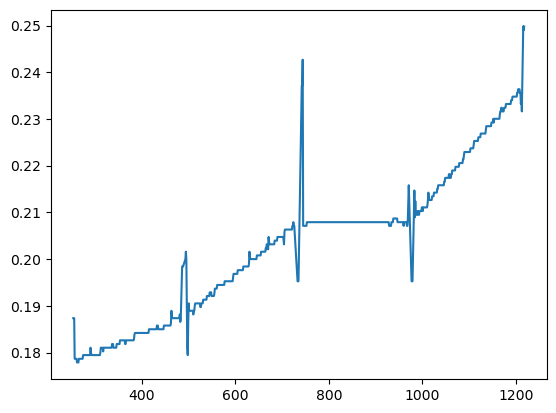

In [148]:
img_yellow = color_separation(original_img, yellow_lowerb, yellow_upperb)
edges, contours = find_contour(img_yellow)
x_axis_con1, y_axis_value1 = continuous(contours)
cur_legend1 = current_legend(contours)
plt.plot(x_axis_con1, y_axis_value1)

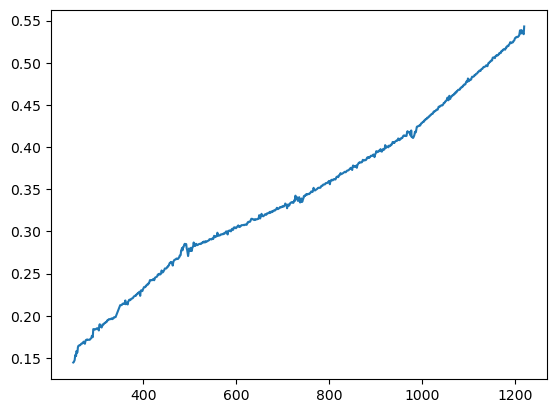

In [200]:
img_blue = color_separation(original_img, blue_lowerb, blue_upperb)
edges, contours = find_contour(img_blue)
x_axis_con2, y_axis_value2 = continuous(contours)
cur_legend2 = current_legend(contours)
plt.plot(x_axis_con2, y_axis_value2)

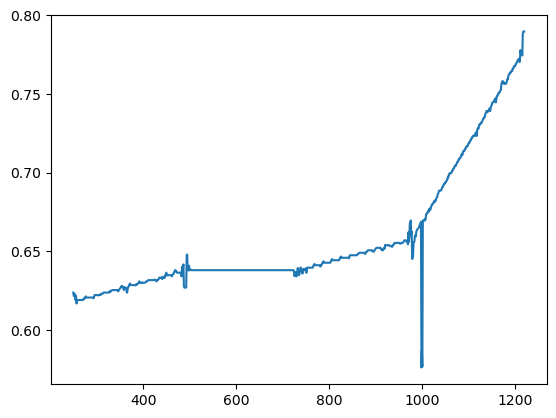

In [201]:
img_purple = color_separation(original_img, purple_lowerb, purple_upperb)
edges, contours = find_contour(img_purple)
x_axis_con3, y_axis_value3 = continuous(contours)
cur_legend3 = current_legend(contours)
plt.plot(x_axis_con3, y_axis_value3)

In [211]:
# change time
def x_axis_change(x_axis_con, x_real_pixel, x_axis):
    x_axis_con_t = []
    for i, m in enumerate(x_axis_con):
        if x_real_pixel[0] <= m < x_real_pixel[1]:
            time = x_axis[0] + '_' + str(m)
        elif x_real_pixel[1] <= m < x_real_pixel[2]:
            time = x_axis[1] + '_' + str(m)
        elif x_real_pixel[2] <= m < x_real_pixel[3]:
            time = x_axis[2] + '_' + str(m)
        elif x_real_pixel[3] <= m < x_real_pixel[4]:
            time = x_axis[3] + '_' + str(m)
        else:
            time = x_axis[4] + '_' + str(m)
        x_axis_con_t.append(time) 

    return x_axis_con_t

x_axis_con_t = x_axis_change(x_axis_con, x_real_pixel, x_axis)
x_axis_con_t1 = x_axis_change(x_axis_con1, x_real_pixel, x_axis)
x_axis_con_t2 = x_axis_change(x_axis_con2, x_real_pixel, x_axis)
x_axis_con_t3 = x_axis_change(x_axis_con3, x_real_pixel, x_axis)


In [207]:
dat = {'time': x_axis_con_t, cur_legend: y_axis_value}
da = pd.DataFrame(dat)
da

,time,Linkedin
0,2012_254,0.188933
1,2012_255,0.188933
2,2012_256,0.194353
3,2012_257,0.198419
4,2012_258,0.198419
...,...,...
936,2015_1214,0.296443
937,2015_1215,0.295652
938,2015_1217,0.299605
939,2015_1218,0.291700


In [224]:
dat1 = {'time': x_axis_con_t1, cur_legend1: y_axis_value1}
da1 = pd.DataFrame(dat1)
da1

,time,Twitter
0,2012_253,0.187352
1,2012_254,0.187352
2,2012_255,0.187352
3,2012_256,0.178656
4,2012_257,0.178656
...,...,...
931,2015_1212,0.234783
932,2015_1213,0.231621
933,2015_1216,0.249802
934,2015_1217,0.249012


In [225]:
da2 = pd.DataFrame({'time': x_axis_con_t2, cur_legend2: y_axis_value2})
da3 = pd.DataFrame({'time': x_axis_con_t3, cur_legend3: y_axis_value3})

In [228]:
  dfs = [da, da1, da2, da3]
data = reduce(lambda left, right: pd.merge(left, right, on='time', how='inner'), dfs)
data

,time,Linkedin,Twitter,Instagram,Facebook
0,2012_254,0.188933,0.187352,0.154045,0.618972
1,2012_255,0.188933,0.187352,0.152253,0.621607
2,2012_256,0.194353,0.178656,0.158261,0.616759
3,2012_257,0.198419,0.178656,0.156162,0.618182
4,2012_258,0.198419,0.178656,0.156838,0.618972
...,...,...,...,...,...
911,2015_1211,0.285375,0.233202,0.536285,0.777866
912,2015_1212,0.285827,0.234783,0.534651,0.775494
913,2015_1213,0.296443,0.231621,0.538735,0.775494
914,2015_1217,0.299605,0.249012,0.534545,0.789723


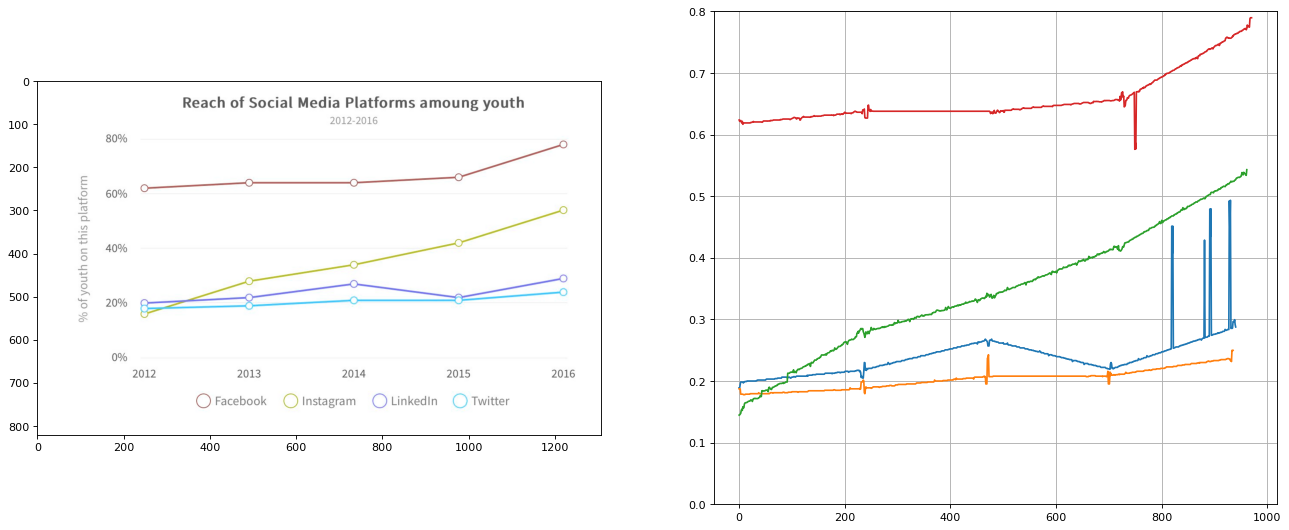

In [268]:
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
ax[0].imshow(original_img)
# ax[1].plot(x_outliers_removed, y_outliers_removed)
ax[1].plot(y_axis_value)
ax[1].plot(y_axis_value1)
ax[1].plot(y_axis_value2)
ax[1].plot(y_axis_value3)
ax[1].set_ylim(0,0.8)
ax[1].grid()

## Deleting unusual value (or outliers)

### Standard Deviation Method

In [ ]:
# calculate summary statistics
data_mean, data_std = np.mean(y_axis_value), np.std(y_axis_value)

# identify outliers
cut_off = data_std * 2
lower, upper = data_mean - cut_off, data_mean + cut_off

# identify outliers
outliers = [x for x in y_axis_value if x < lower or x > upper]
# remove outliers
outliers_removed = [x for x in y_axis_value if x >= lower and x <= upper]
ic(len(outliers), len(outliers_removed))

ic| len(outliers): 10, len(outliers_removed): 931


(10, 931)

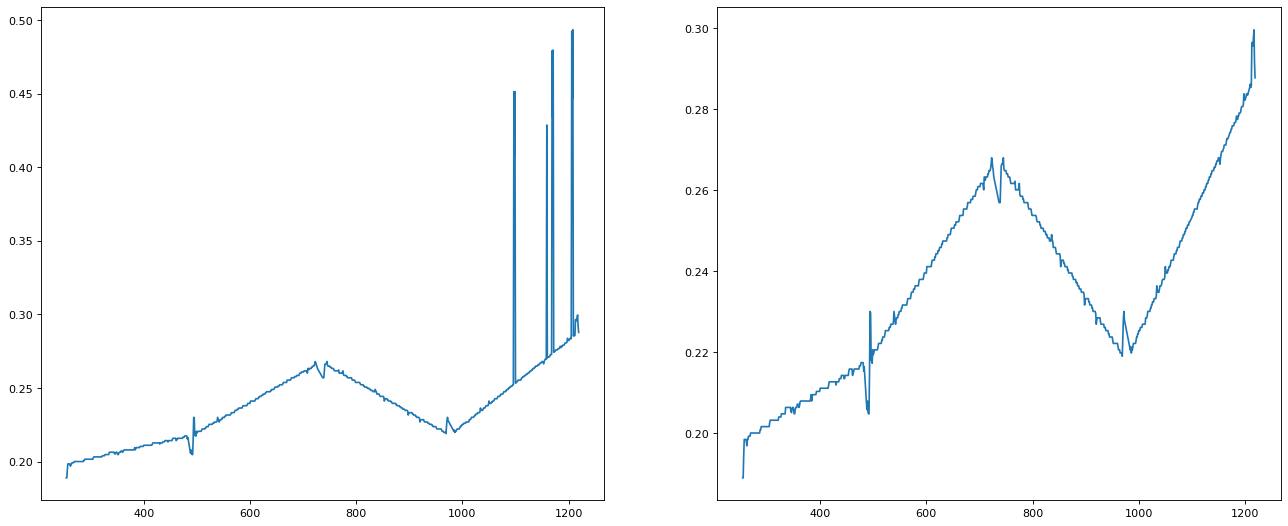

In [ ]:
dat = {'time': x_axis_con, 'yellow':y_axis_value}
data = pd.DataFrame(dat)

df_outliers_removed = data[data.yellow.isin(outliers_removed)]
x_outliers_removed = df_outliers_removed.time.values
y_outliers_removed = df_outliers_removed.yellow.values

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
ax[0].plot(x_axis_con, y_axis_value)
ax[1].plot(x_outliers_removed, y_outliers_removed)

### Interquartile Range Method

In [230]:
def iqr(y_axis_value):
    # calculate interquartile range
    q25, q75 = np.percentile(y_axis_value, 25), np.percentile(y_axis_value, 75)
    iqr = q75 - q25
    # print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))

    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    # identify outliers
    outliers = [x for x in y_axis_value if x < lower or x > upper]
    # print('Identified outliers: %d' % len(outliers))
    # remove outliers
    outliers_removed = [x for x in y_axis_value if x >= lower and x <= upper]
    # print('Non-outlier observations: %d' % len(outliers_removed))

    return outliers, outliers_removed

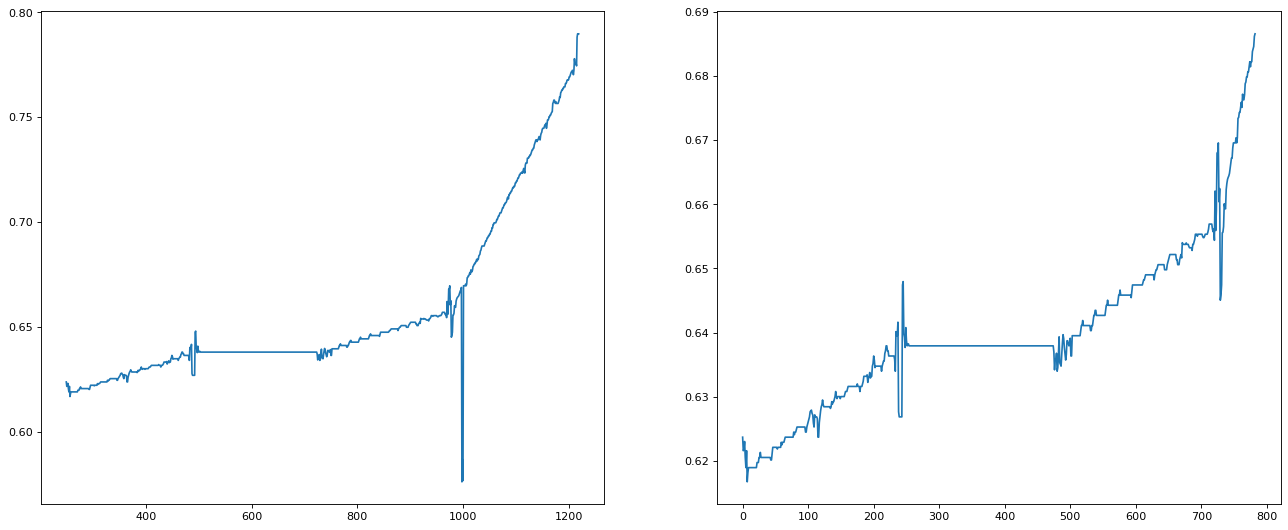

In [240]:
outliers, outliers_removed = iqr(y_axis_value3)

df_outliers_removed = da3[da3.Facebook.isin(outliers_removed)]
x_outliers_removed = df_outliers_removed.time.values
y_outliers_removed = df_outliers_removed.Facebook.values

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
ax[0].plot(x_axis_con3, y_axis_value3)
# ax[1].plot(x_outliers_removed, y_outliers_removed)
ax[1].plot(y_outliers_removed)

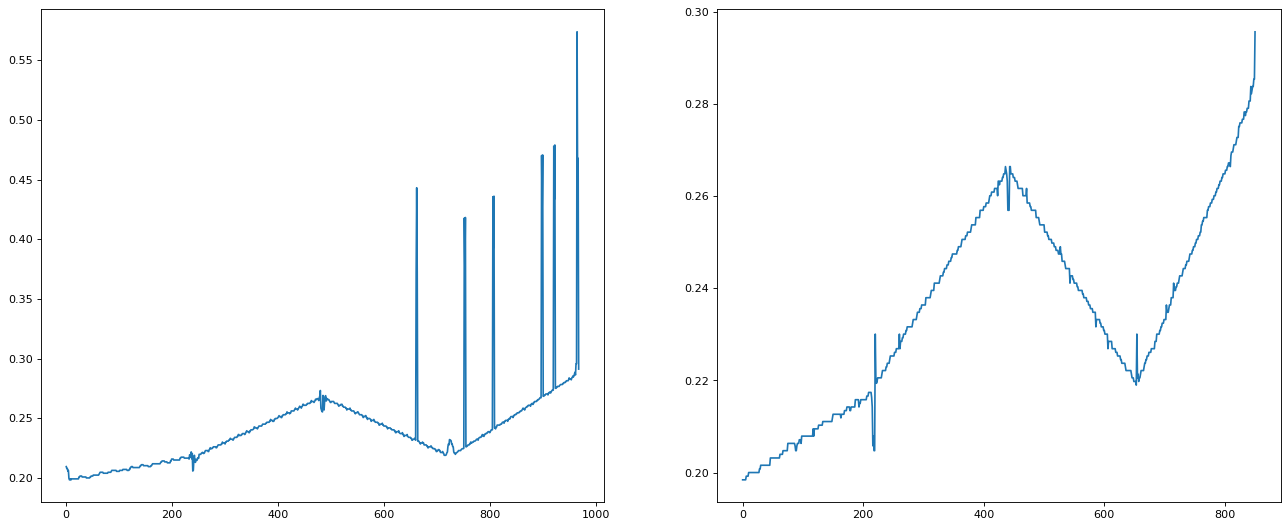

In [376]:
outliers, outliers_removed = iqr(y_axis_value)

df_outliers_removed = da[da.Linkedin.isin(outliers_removed)]
x_outliers_removed = df_outliers_removed.time.values
y_outliers_removed = df_outliers_removed.Linkedin.values

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
ax[0].plot(y_axis_value)
# ax[1].plot(x_outliers_removed, y_outliers_removed)
ax[1].plot(y_outliers_removed)

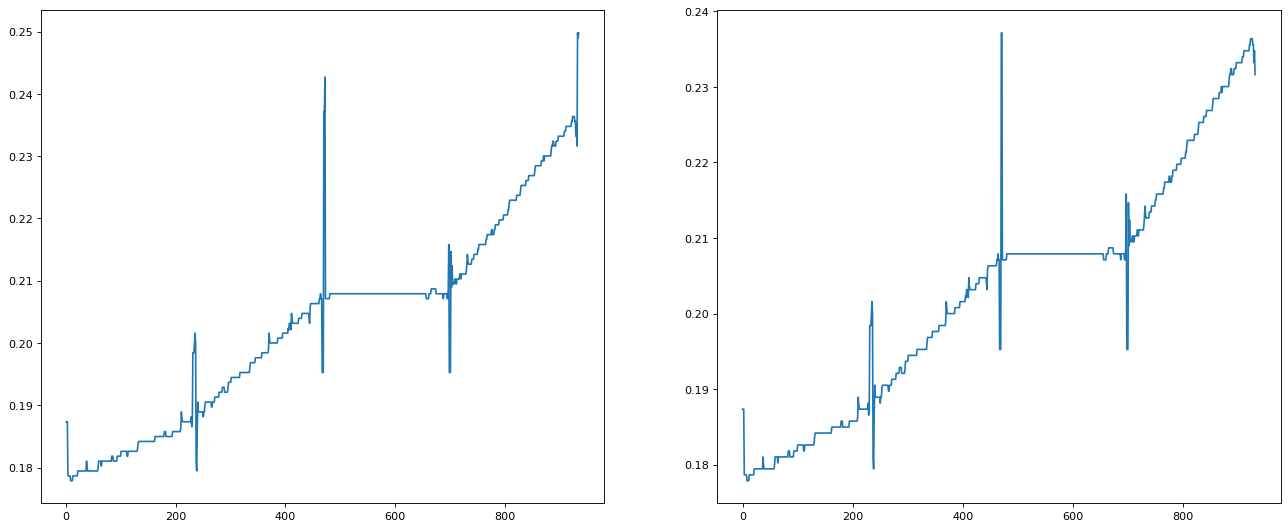

In [379]:
outliers, outliers_removed = iqr(y_axis_value1)

df_outliers_removed = da1[da1.Twitter.isin(outliers_removed)]
x_outliers_removed = df_outliers_removed.time.values
y_outliers_removed = df_outliers_removed.Twitter.values

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
ax[0].plot(y_axis_value1)
# ax[1].plot(x_outliers_removed, y_outliers_removed)
ax[1].plot(y_outliers_removed)

Moving average

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8         NaN
9    0.181107
dtype: float64


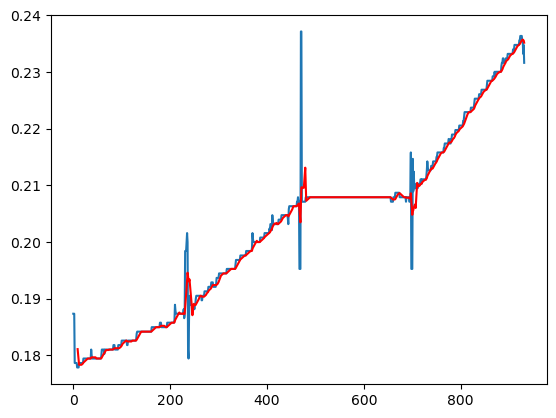

: 

In [384]:

from matplotlib import pyplot
series = pd.Series(y_outliers_removed)
# Tail-rolling average transform
rolling = series.rolling(window=10)
rolling_mean = rolling.mean()
print(rolling_mean.head(10))
# plot original and transformed dataset
series.plot()
rolling_mean.plot(color='red')
pyplot.show()

### Sliding window

In [1]:
outliers_removed = []
len_window = 40
for i in range((len(y_axis_value) // len_window) + 1):
    window_outliers_removed = iqr(y_axis_value[len_window*i : len_window*(i+1)])
    outliers_removed.append(window_outliers_removed)

ic(len(outliers_removed))
outliers_removed = [item for sub_list in outliers_removed for item in sub_list]
ic(len(outliers_removed))

NameError: name 'y_axis_value' is not defined

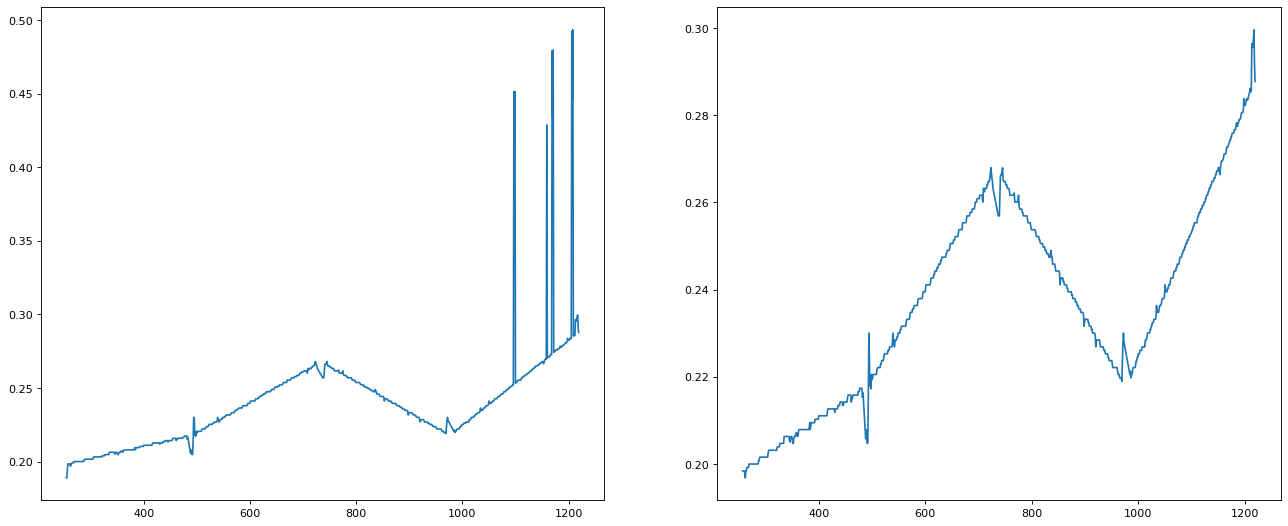

In [ ]:
df_outliers_removed = data[data.yellow.isin(outliers_removed)]
x_outliers_removed = df_outliers_removed.time.values
y_outliers_removed = df_outliers_removed.yellow.values

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
ax[0].plot(x_axis_con, y_axis_value)
ax[1].plot(x_outliers_removed, y_outliers_removed)

In [370]:
def sliding_window(len_window, y_axis_value):
    outliers_removed = []
    for i in range((len(y_axis_value) // len_window) + 1):
        _, window_outliers_removed = iqr(y_axis_value[len_window*i : len_window*(i+1)])
        outliers_removed.append(window_outliers_removed)

    # ic(len(outliers_removed))
    outliers_removed = [item for sub_list in outliers_removed for item in sub_list]
    # ic(len(outliers_removed))

    return outliers_removed

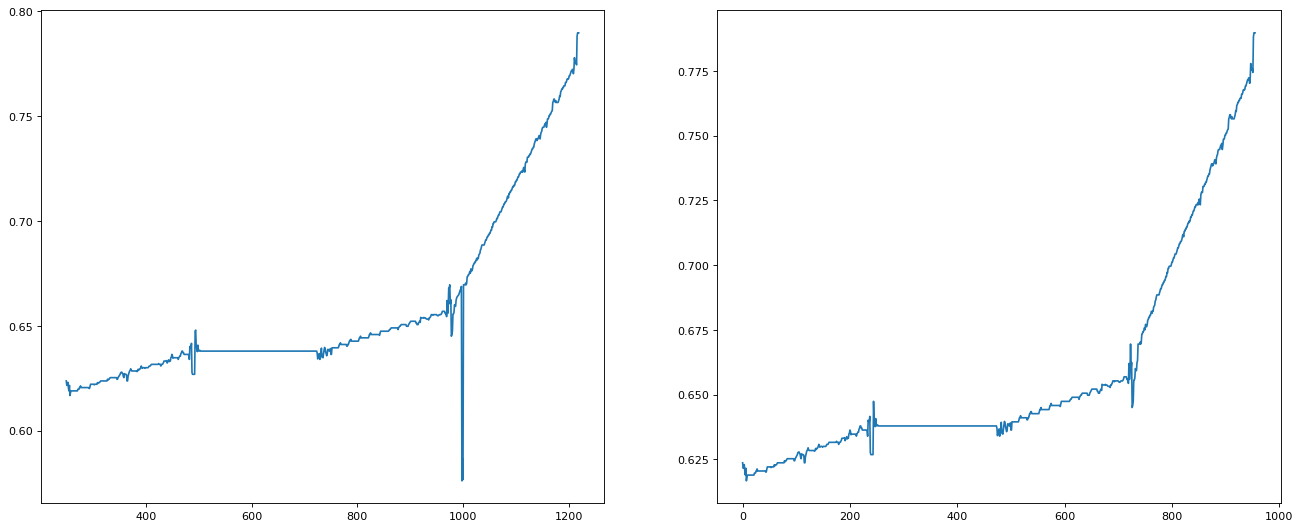

In [373]:
len_window = 150
outliers_removed = sliding_window(len_window, y_axis_value3)

df_outliers_removed = da3[da3.Facebook.isin(outliers_removed)]
x_outliers_removed = df_outliers_removed.time.values
y_outliers_removed = df_outliers_removed.Facebook.values

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
ax[0].plot(x_axis_con3, y_axis_value3)
# ax[1].plot(x_outliers_removed, y_outliers_removed)
ax[1].plot(y_outliers_removed)